# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
!pwd

/p/Users/andy/Dropbox/_UDACITY/Reinforcement Learning/DeepReinforcement-Competing-Tennis-Agents - MADDPG


In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
print(brain)

Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
runSample=False  #set to true to run sample/take random actions in environment

In [8]:

if (runSample): 
    for i in range(1, 6):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [9]:
if (runSample): 
    env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## implement DDPG policy

### Setup Parameters

This uses a basic structure 'Parameters' to encapsalate all common parameters

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Parameters import Parameters

p=Parameters()
p.set_defaults()
p.BATCH_SIZE=256
p.STEPS_BEFORE_LEARN=20
p.NUM_LEARN_STEPS=100
p.STATE_SIZE=state_size
p.ACTION_SIZE=action_size
p.NUM_AGENTS=num_agents
p.BUFFER_SIZE=int(1.0e5)
#p.LR_ACTOR=.0001
#p.LR_CRITIC=.001
p.LR_ACTOR=.0001
p.LR_CRITIC=.001
#p.TAU = 0.06
p.TAU = 0.04
p.WEIGHT_DECAY=0
p.EPSILON=.99
#p.EPSILON_DECAY=.998
p.EPSILON_DECAY=.9998
p.GAMMA = 0.95
p.GAMMA_DECAY = 1.0001
p.NOISE_SIGMA=0.3
p.DEVICE= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = p.DEVICE

print(p)

Parameters:
STATE_SIZE(0):24
ACTION_SIZE(0):2
NUM_AGENTS(0):2
RANDOM_SEED(1):1
BUFFER_SIZE(ie5):100000
BATCH_SIZE(512):256
STEPS_BEFORE_LEARN(15) :20
NUM_LEARN_STEPS(10):100
GAMMA(.99):0.95
GAMMA_MAX(.99):0.99
GAMMA_DECAY(1.001):1.0001
TAU Size(1e-3):0.04
LR_ACTOR(ie-4):0.0001
LR_CRITIC(1e-5):0.001
WEIGHT_DECAY(0):0
DEVICE(cpu):cuda:0
EPSILON(1.0):0.99
EPSILON_MIN(.1) :0.1
EPSILON_DECAY(.995) :0.9998
NOISE_SIGMA(0.2):0.3



In [11]:
#from ddpg_agent import DDPGAgent
#agent = DDPGAgent(p)
from maddpg_agent import DDPGAgent,MADDPGAgent
agent = MADDPGAgent(p)

C:\Users\andy\AppData\Local\conda\conda\envs\deeprl\lib\site-packages\torch\cuda\__init__.py:116: UserWarning: 
    Found GPU1 GeForce GTX 670 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### savePrintScores()

prints progresss and saves network

- in parameters:
    - i_episode     :   current episode
    - save_interval :   how often to save network
    - score_average :   current average of scores
    - scores        :   current scores
    - p             :   parameter object
    

In [32]:
solved=False

def save_print_scores(i_episode,save_interval,score_average,scores,max_score, p):
    global solved
    if score_average<=0.5:
        print('\r         Episode {}, Average Score: {:.2f}, Std Dev: {:.2f}, Eps: {:.2f}, gam: {:.2f}'\
              .format(i_episode, score_average, np.std(scores), p.EPSILON, p.GAMMA), end="\n")        

    if i_episode % save_interval==0 and not solved:
        print("not saving")
        for i in range(p.NUM_AGENTS):
            torch.save(agent.agents[i].actor_local.state_dict(), 'checkpoints\checkpoint_actor1_opt.pth')
            torch.save(agent.agents[i].actor_local.state_dict(), 'checkpoints\checkpoint_actor2_opt.pth')

    if score_average > 0.5:
        solved=True
        print('\r*solved* Episode {}, Average Score: {:.2f}, Std Dev: {:.2f}, Eps: {:.2f}, gam: {:.2f}'\
              .format(i_episode, score_average, np.std(scores), p.EPSILON, p.GAMMA), end="\n")        
        #print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average))
        if score_average == max_score:
            print("\r saving.")
            for i in range(p.NUM_AGENTS):
                torch.save(agent.agents[i].actor_local.state_dict(), 'checkpoints\optimum_checkpoint_actor1_opt.pth')
                torch.save(agent.agents[i].actor_local.state_dict(), 'checkpoints\optimum_checkpoint_actor2_opt.pth')

### updateLrSteps()

updates Learning Rate and number of steps

- in parameters:
    - i_episode     :   current episode
    - p             :   parameter object
    

In [31]:
def updateLrSteps(i_episode,score_average):
    if i_episode == 1000:
        p.STEPS_BEFORE_LEARN=40
        p.NUM_LEARN_STEPS=30
        agent.lr_step()
    if i_episode  == 3000:
        p.STEPS_BEFORE_LEARN=50
        p.NUM_LEARN_STEPS=20
    if score_average > 0.5:
        p.STEPS_BEFORE_LEARN=10
        p.NUM_LEARN_STEPS=10

In [14]:
from collections import deque

average_period=100
scores_deque = deque(maxlen=average_period)
scores_global = []
average_global = []

p.STEPS_BEFORE_LEARN=5
p.NUM_LEARN_STEPS=25


def ddpg(n_episodes=10000,save_interval=100):
    max_score=0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        prev_states=states
        agent.reset()
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        score_average = 0
        while(True):
            actions = agent.act(prev_states,states, add_noise=True)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if any episode finished
            agent.step(prev_states, states, actions, rewards, next_states, dones) # take a step using agent
            prev_states = states
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)
            if np.any(dones):                                  # exit loop if episode finished
                break
                
        score = np.mean(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        average_global.append(score_average)
        if score_average>max_score:
            max_score=score_average

        #updateLrSteps(i_episode,score_average)

        p.EPSILON = max(p.EPSILON * p.EPSILON_DECAY,p.EPSILON_MIN)
        p.GAMMA = min(p.GAMMA_MAX,p.GAMMA*p.GAMMA_DECAY)
        
        save_print_scores(i_episode,save_interval,score_average,scores,max_score,p)
        
        if score_average >=1.0: 
                break

    return scores_global, average_global

scores, averages = ddpg()


         Episode 1, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 2, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 3, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 4, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 5, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 6, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 7, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 8, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 9, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 10, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 11, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 12, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 13, Average Score: -0.00, Std Dev: 0.00, Eps

         Episode 105, Average Score: -0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 106, Average Score: -0.00, Std Dev: 0.06, Eps: 0.97, gam: 0.96
         Episode 107, Average Score: -0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 108, Average Score: -0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 109, Average Score: -0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 110, Average Score: -0.00, Std Dev: 0.06, Eps: 0.97, gam: 0.96
         Episode 111, Average Score: -0.00, Std Dev: 0.05, Eps: 0.97, gam: 0.96
         Episode 112, Average Score: -0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 113, Average Score: -0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 114, Average Score: -0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 115, Average Score: -0.00, Std Dev: 0.05, Eps: 0.97, gam: 0.96
         Episode 116, Average Score: -0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 117, Average Score: -0.

         Episode 209, Average Score: 0.03, Std Dev: 0.00, Eps: 0.95, gam: 0.97
         Episode 210, Average Score: 0.03, Std Dev: 0.06, Eps: 0.95, gam: 0.97
         Episode 211, Average Score: 0.03, Std Dev: 0.06, Eps: 0.95, gam: 0.97
         Episode 212, Average Score: 0.03, Std Dev: 0.05, Eps: 0.95, gam: 0.97
         Episode 213, Average Score: 0.04, Std Dev: 0.06, Eps: 0.95, gam: 0.97
         Episode 214, Average Score: 0.04, Std Dev: 0.06, Eps: 0.95, gam: 0.97
         Episode 215, Average Score: 0.04, Std Dev: 0.06, Eps: 0.95, gam: 0.97
         Episode 216, Average Score: 0.04, Std Dev: 0.00, Eps: 0.95, gam: 0.97
         Episode 217, Average Score: 0.04, Std Dev: 0.05, Eps: 0.95, gam: 0.97
         Episode 218, Average Score: 0.04, Std Dev: 0.00, Eps: 0.95, gam: 0.97
         Episode 219, Average Score: 0.04, Std Dev: 0.05, Eps: 0.95, gam: 0.97
         Episode 220, Average Score: 0.04, Std Dev: 0.06, Eps: 0.95, gam: 0.97
         Episode 221, Average Score: 0.04, Std Dev: 

         Episode 313, Average Score: 0.05, Std Dev: 0.06, Eps: 0.93, gam: 0.98
         Episode 314, Average Score: 0.05, Std Dev: 0.06, Eps: 0.93, gam: 0.98
         Episode 315, Average Score: 0.05, Std Dev: 0.00, Eps: 0.93, gam: 0.98
         Episode 316, Average Score: 0.05, Std Dev: 0.05, Eps: 0.93, gam: 0.98
         Episode 317, Average Score: 0.05, Std Dev: 0.05, Eps: 0.93, gam: 0.98
         Episode 318, Average Score: 0.05, Std Dev: 0.05, Eps: 0.93, gam: 0.98
         Episode 319, Average Score: 0.05, Std Dev: 0.05, Eps: 0.93, gam: 0.98
         Episode 320, Average Score: 0.05, Std Dev: 0.06, Eps: 0.93, gam: 0.98
         Episode 321, Average Score: 0.05, Std Dev: 0.05, Eps: 0.93, gam: 0.98
         Episode 322, Average Score: 0.05, Std Dev: 0.06, Eps: 0.93, gam: 0.98
         Episode 323, Average Score: 0.05, Std Dev: 0.00, Eps: 0.93, gam: 0.98
         Episode 324, Average Score: 0.05, Std Dev: 0.06, Eps: 0.93, gam: 0.98
         Episode 325, Average Score: 0.05, Std Dev: 

         Episode 417, Average Score: 0.06, Std Dev: 0.06, Eps: 0.91, gam: 0.99
         Episode 418, Average Score: 0.06, Std Dev: 0.06, Eps: 0.91, gam: 0.99
         Episode 419, Average Score: 0.06, Std Dev: 0.00, Eps: 0.91, gam: 0.99
         Episode 420, Average Score: 0.06, Std Dev: 0.00, Eps: 0.91, gam: 0.99
         Episode 421, Average Score: 0.06, Std Dev: 0.06, Eps: 0.91, gam: 0.99
         Episode 422, Average Score: 0.06, Std Dev: 0.00, Eps: 0.91, gam: 0.99
         Episode 423, Average Score: 0.06, Std Dev: 0.05, Eps: 0.91, gam: 0.99
         Episode 424, Average Score: 0.07, Std Dev: 0.00, Eps: 0.91, gam: 0.99
         Episode 425, Average Score: 0.07, Std Dev: 0.06, Eps: 0.91, gam: 0.99
         Episode 426, Average Score: 0.07, Std Dev: 0.00, Eps: 0.91, gam: 0.99
         Episode 427, Average Score: 0.07, Std Dev: 0.05, Eps: 0.91, gam: 0.99
         Episode 428, Average Score: 0.07, Std Dev: 0.06, Eps: 0.91, gam: 0.99
         Episode 429, Average Score: 0.07, Std Dev: 

         Episode 521, Average Score: 0.38, Std Dev: 0.00, Eps: 0.89, gam: 0.99
         Episode 522, Average Score: 0.41, Std Dev: 0.00, Eps: 0.89, gam: 0.99
         Episode 523, Average Score: 0.43, Std Dev: 0.06, Eps: 0.89, gam: 0.99
         Episode 524, Average Score: 0.43, Std Dev: 0.00, Eps: 0.89, gam: 0.99
         Episode 525, Average Score: 0.44, Std Dev: 0.05, Eps: 0.89, gam: 0.99
         Episode 526, Average Score: 0.44, Std Dev: 0.06, Eps: 0.89, gam: 0.99
         Episode 527, Average Score: 0.44, Std Dev: 0.06, Eps: 0.89, gam: 0.99
         Episode 528, Average Score: 0.45, Std Dev: 0.00, Eps: 0.89, gam: 0.99
         Episode 529, Average Score: 0.46, Std Dev: 0.00, Eps: 0.89, gam: 0.99
         Episode 530, Average Score: 0.46, Std Dev: 0.06, Eps: 0.89, gam: 0.99
         Episode 531, Average Score: 0.46, Std Dev: 0.05, Eps: 0.89, gam: 0.99
         Episode 532, Average Score: 0.46, Std Dev: 0.05, Eps: 0.89, gam: 0.99
         Episode 533, Average Score: 0.49, Std Dev: 

In [29]:
for i in range(p.NUM_AGENTS):
    torch.save(agent.agents[i].actor_local.state_dict(), 'checkpoints\optimum_checkpoint_actor1_opt.pth')
    torch.save(agent.agents[i].actor_local.state_dict(), 'checkpoints\optimum_checkpoint_actor2_opt.pth')

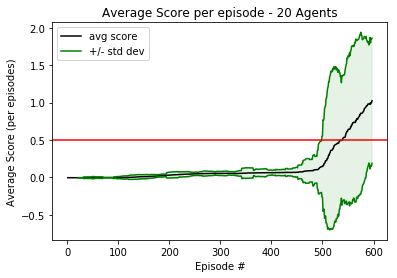

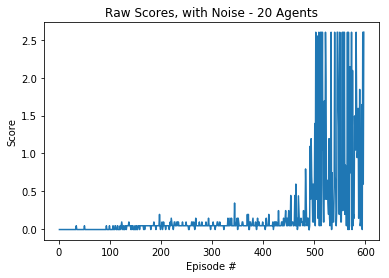

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


stdm=[average_global[i]-np.std(scores_global[i-20:i+3]) for i in range(len(scores_global))]
stdp=[average_global[i]+np.std(scores_global[i-20:i+3]) for i in range(len(scores_global))]

plt.plot(np.arange(1, len(scores_global)+1), average_global,color='black',label='avg score')
plt.plot(np.arange(1, len(scores_global)+1), stdm,color='green',label='+/- std dev')
plt.plot(np.arange(1, len(scores_global)+1), stdp,color='green')
plt.fill_between(range(len(scores_global)),
                 stdm,
                 stdp,
                 color='green',alpha=0.1,interpolate=True)
plt.title("Average Score per episode - 20 Agents")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Average Score (per episodes)')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.title("Raw Scores, with Noise - 20 Agents")
plt.plot(np.arange(1, len(scores_global)+1), scores_global)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
import time
rscores_deque = deque(maxlen=average_period)
rscores_global = []
raverage_global = []

def run_agent(n_episodes=100):
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        prev_states=states
        agent.reset()
        rscores = np.zeros(num_agents)                          # initialize the score (for each agent)
        time.sleep(3)
        
        while(True):
            actions = agent.act(prev_states,states, add_noise=False)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if any episode finished
            prev_states = states
            states = next_states                               # roll over states to next time step
            rscores += rewards                                  # update the score (for each agent)            
            if np.any(dones):                                  # exit loop if episode finished
                break

        rscore = np.mean(rscores)
        rscores_deque.append(rscore)
        rscore_average = np.mean(rscores_deque)
        rscores_global.append(rscore)
        raverage_global.append(rscore_average)
        print("run score=",rscore," average=",rscore_average)
        
        
    return rscores_global,raverage_global

rscores,raverage=run_agent()
print("rscore=",rscores,raverage)


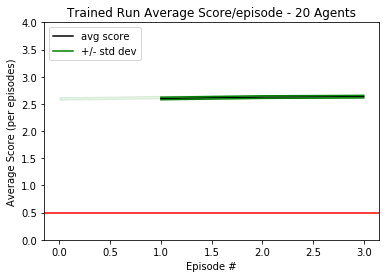

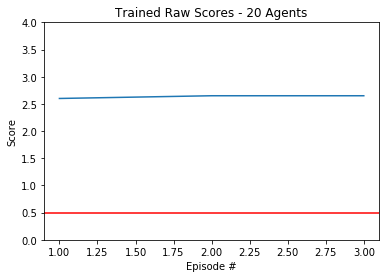

In [30]:
stdm=[raverage_global[i]-np.std(rscores_global[i-5:i+3]) for i in range(len(rscores_global))]
stdp=[raverage_global[i]+np.std(rscores_global[i-5:i+3]) for i in range(len(rscores_global))]

plt.plot(np.arange(1, len(rscores_global)+1), raverage_global,color='black',label='avg score')
plt.plot(np.arange(1, len(rscores_global)+1), stdm,color='green',label='+/- std dev')
plt.plot(np.arange(1, len(rscores_global)+1), stdp,color='green')
plt.ylim(0, 4)
plt.fill_between(range(len(rscores_global)),
                 stdm,
                 stdp,
                 color='green',alpha=0.1,interpolate=True)
plt.title("Trained Run Average Score/episode - 20 Agents")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Average Score (per episodes)')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.ylim(0, 4)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.title("Trained Raw Scores - 20 Agents")
plt.plot(np.arange(1, len(rscores_global)+1), rscores_global)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()